# Imports & Preprocessing

In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import sklearn.metrics, sklearn.neighbors, sklearn.model_selection

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
dirpath = 'IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


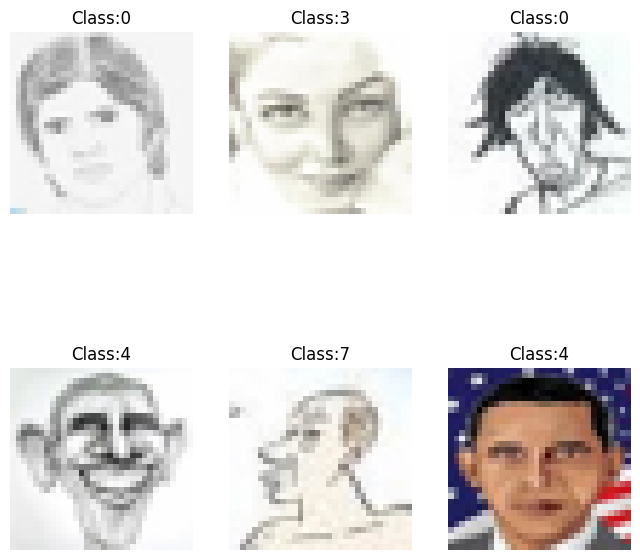

In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

# Dimensionality Reduction using PCA

In [6]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X, N):
        X_mean = np.mean(X,axis=0)
        X -= X_mean
        cov = np.cov(X.reshape(N, -1).T)
        eigs = np.linalg.eigh(cov)
        l = [[eigs[0][i], i] for i in range(len(eigs[0]))]
        l = np.array(sorted(l, key=lambda x:x[0], reverse=True))
        l2 = l[:, 1]
        
        return eigs, l, l2
    
    def calc(self, X, N, eigs, l, l2):
        eig_vecs = np.array([eigs[1][int(i), :] for i in l2[:self.n_components]])
        
        X_new = np.dot(X.reshape(N, -1), eig_vecs.T)
        
        var = np.sum(l[:self.n_components, 0])
        
        return X_new, var

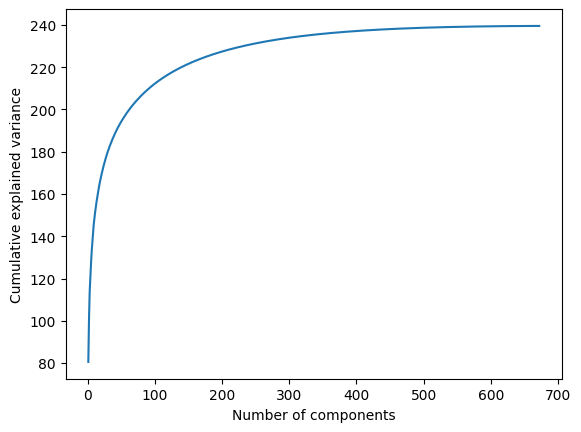

In [7]:
x = np.arange(1, X.shape[0]+1)
y = np.zeros(X.shape[0])
pca = PCA(n_components=2)
eigs, l, l2 = pca.fit(X, N)
for i in range(X.shape[0]):
    pca.n_components=i+1
    X_new, var = pca.calc(X, N, eigs, l, l2)
    y[i] = var
    
plt.plot(x, y)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

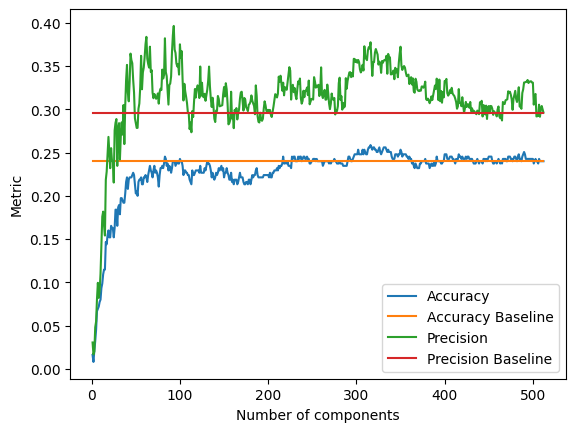

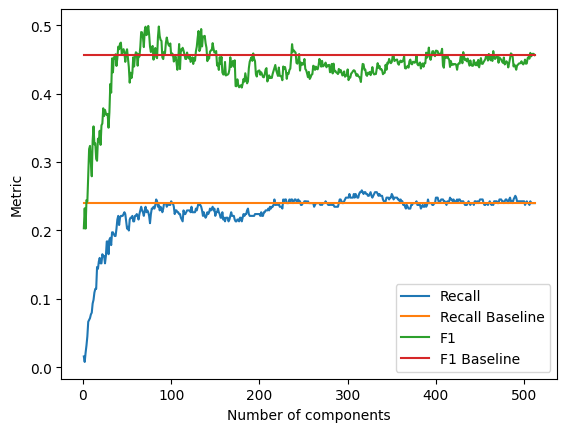

In [14]:
f = np.load('data.npy', allow_pickle=True)

embs = f[:][:, 2]
classes = f[:][:, 3]

embs = np.array([i[0] for i in embs])


pca = PCA(n_components=embs.shape[1])
eigs, l, l2 = pca.fit(embs, embs.shape[0])
new_embs, var = pca.calc(embs, embs.shape[0], eigs, l, l2)

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, metric='euclidean')
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(new_embs, classes, test_size=0.25, random_state=0)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred)
precision = sklearn.metrics.precision_score(y_valid, y_pred, average='weighted', zero_division=np.nan)
recall = sklearn.metrics.recall_score(y_valid, y_pred, average='weighted', zero_division=np.nan)
f1 = sklearn.metrics.f1_score(y_valid, y_pred, average='weighted', zero_division=np.nan)

accuracies = [accuracy]
precisions = [precision]
recalls = [recall]
f1scores = [f1]

x = np.arange(1, embs.shape[1]+1)

for i in range(embs.shape[1]):
    pca.n_components=i+1
    new_embs, var = pca.calc(embs, embs.shape[0], eigs, l, l2)

    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(new_embs, classes, test_size=0.25, random_state=0)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred)
    precision = sklearn.metrics.precision_score(y_valid, y_pred, average='weighted', zero_division=np.nan)
    recall = sklearn.metrics.recall_score(y_valid, y_pred, average='weighted', zero_division=np.nan)
    f1 = sklearn.metrics.f1_score(y_valid, y_pred, average='weighted', zero_division=np.nan)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    
accs = [accuracies[0] for _ in range(len(x))]
precs = [precisions[0] for _ in range(len(x))]
recs = [recalls[0] for _ in range(len(x))]
f1s = [f1scores[0] for _ in range(len(x))]
plt.plot(x, accuracies[1:], label='Accuracy')
plt.plot(x, accs, '-', label='Accuracy Baseline')
plt.plot(x, precisions[1:], label='Precision')
plt.plot(x, precs, '-', label='Precision Baseline')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.legend()
plt.show()
plt.plot(x, recalls[1:], label='Recall')
plt.plot(x, recs, '-', label='Recall Baseline')
plt.plot(x, f1scores[1:], label='F1')
plt.plot(x, f1s, '-', label='F1 Baseline')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.legend()
plt.show()

## Observations

* We observe from the above graph that the Accuracy, Precision, Recall or F1-score have a certain `elbow point` till which the metric grows as the number of principal components in PCA increase, after which it stagnates.
* Therefore, we observe that `removal of dimensions` after the elbow point would not make significant difference to the classifier's accuracies.

# Pictionary Dataset

['d_drawer', 'd_area_median', 'd_stroke_freq_median', 'd_rangestroketime_median', 'd_firststroketime_median', 'd_laststroketime_median', 'd_pcgamestup', 'd_pcgamestdown', 'd_pcgameserasehighlight']
[[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [36.0, 82306.7497627424, 0.5788022188618911, 21.65999984741211, 3.5119998455047607, 26.81500005722046, 0.0, 0.0, 0.7777777777777778], [14.0, 60929.32843182045, 0.2391676951617906, 25.08700013160706, 1.368000030517578, 26.45500016212464, 1.0, 1.0, 1.0], [26.0, 119037.63797572337, 0.4025330237376816, 54.16199994087219, 2.458999991416931, 56.62099993228912, 0.75, 0.5, 1.0], [40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [22.0, 45417.72340743454, 0.3159646876463749, 85.94549989700317, 3.771000027656555, 89.71649992465973, 0.0, 0.0, 1.0], [39.0, 38940.06036869295, 0.5522079884988065, 11.594499945640564, 3.2070000171661377, 14.740000009536743, 0.0, 0.25, 0.375], [78.0, 120257.06428960172, 0.3398684196358139, 26.20450007915497, 2.2925000190734863, 2

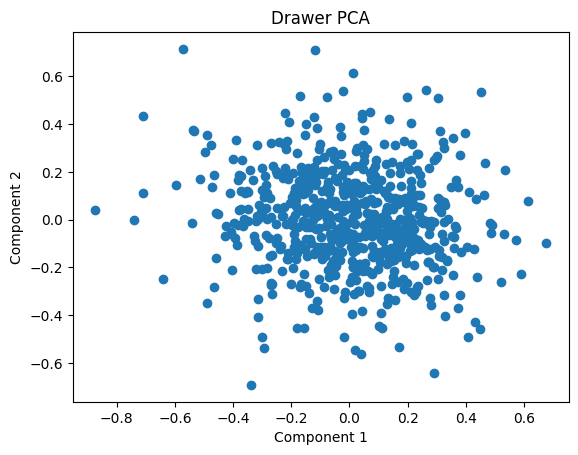

In [16]:
file1 = open('smai_assignment_pictionary/drawer_attributes.csv', 'r')

headers = file1.readline().strip().split(',')

l = []
while True:
    line = file1.readline()
    if line == '':
        break
    x = line.strip().split(',')
    x = [float(i) for i in x]
    l.append(x)

print(headers)    
print(l)

pca = PCA(n_components=2)
eigs, l, l2 = pca.fit(X, N)
drawer_new, var = pca.calc(X, N, eigs, l, l2)

plt.scatter(drawer_new[:, 0], drawer_new[:, 1])
plt.title('Drawer PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

['g_guesser', 'g_noofmessage_median', 'g_firstmessagetime_median', 'g_lastmessagetime_median', 'g_rangemessagetime_median', 'g_pcgamesconfusion', 'g_entropy']
[[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [36.0, 1.0, 25.367172, 39.041594, 0.0, 0.0, 0.0], [14.0, 2.0, 12.98874, 51.351317, 38.362577, 1.0, 0.6931471805599453], [26.0, 3.5, 20.6223455, 64.718058, 44.0957125, 0.0, 1.242453324894], [40.0, 3.0, 30.339558, 78.943003, 48.60344500000001, 0.0, 1.0986122886681096], [22.0, 2.0, 43.310757, 58.8446475, 15.533890499999998, 0.0, 0.5493061443340548], [39.0, 2.0, 20.339757, 36.734931, 12.653512000000005, 0.0, 0.6931471805599453], [78.0, 1.0, 19.0967705, 33.9130605, 0.0, 0.1, 0.0], [73.0, 3.0, 33.466261, 67.673243, 30.487687500000003, 0.0, 1.0986122886681096], [75.0, 3.0, 28.981178, 82.60636, 53.625182, 0.0, 1.0986122886681096], [47.0, 2.0, 15.140042, 34.895863, 15.938878, 0.0, 0.6931471805599453], [70.0, 2.0, 24.894038, 104.567535, 20.29489, 0.0, 0.6931471805599453], [59.0, 2.0, 24.008261, 34.642

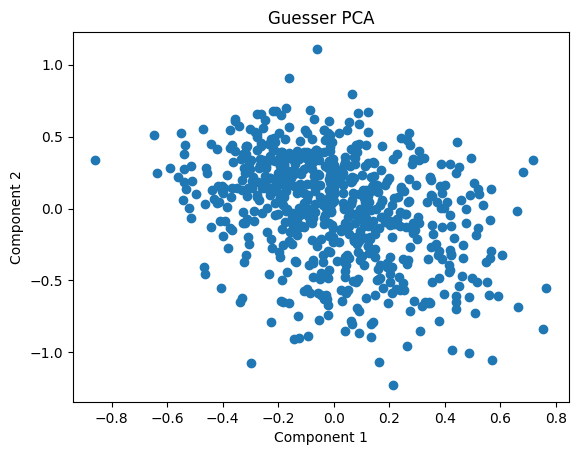

In [17]:
file2 = open('smai_assignment_pictionary/guesser_attributes.csv', 'r')
headers = file2.readline().strip().split(',')

l = []
while True:
    line = file2.readline()
    if line == '':
        break
    x = line.strip().split(',')
    x = [float(i) for i in x]
    l.append(x)
    
print(headers)    
print(l)

pca = PCA(n_components=2)
eigs, l, l2 = pca.fit(X, N)
guesser_new, var = pca.calc(X, N, eigs, l, l2)

plt.scatter(guesser_new[:, 0], guesser_new[:, 1])
plt.title('Guesser PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Observations

*